In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('../data/model_input_with_interactions.csv')


In [15]:
# Define full feature columns with interactions
feature_cols = [
    'gender_encoded',
    'age_group_encoded',
    'severity_encoded',
    'admission_encoded',
    'payment_type_encoded',
    'diagnosis_encoded',
    'procedure_encoded',
    'county_encoded',
    'los',
    'los_x_severity',
    'los_x_procedure',
    'severity_x_procedure',
    'los_x_county'
]

In [16]:
# Load saved models for each LOS group
model_short = joblib.load('../models/model_short.pkl')
model_moderate = joblib.load('../models/model_moderate.pkl')
model_long = joblib.load('../models/model_long.pkl')
model_extended = joblib.load('../models/model_extended.pkl')

## Define LOS Grouping Function

This function assigns each patient to a LOS category to route them to the correct model.

In [18]:
def get_los_group(los):
    if los <= 3:
        return 'short'
    elif los <= 14:
        return 'moderate'
    elif los <= 30:
        return 'long'
    else:
        return 'extended'

## Ensemble Prediction Function

This function uses the predicted LOS group to select the appropriate model and generate a charge prediction.

In [19]:
def ensemble_predict(df, feature_cols):
    df = df.copy()

    # Add LOS group label
    df['los_group'] = df['los'].apply(get_los_group)

    # Prepare output container
    preds = []

    # Loop through LOS groups and apply corresponding model
    for group, model in {
        'short': model_short,
        'moderate': model_moderate,
        'long': model_long,
        'extended': model_extended
    }.items():
        group_df = df[df['los_group'] == group]
        if not group_df.empty:
            X = group_df[feature_cols]
            y_pred_log = model.predict(X)
            y_pred = np.expm1(y_pred_log)  # Inverse log-transform
            preds.append(pd.Series(y_pred, index=group_df.index))

    # Combine all predictions
    df['ensemble_prediction'] = pd.concat(preds).sort_index()
    return df

## Evaluate Ensemble Model Performance

We apply the ensemble prediction to the full dataset and compare predicted vs. actual total charges.

In [20]:
# Apply the ensemble model
df_with_preds = ensemble_predict(df, feature_cols)

# Evaluate performance
y_true = df_with_preds['total_charges']
y_pred = df_with_preds['ensemble_prediction']
mae_ensemble = mean_absolute_error(y_true, y_pred)

print(f"Ensemble MAE: ${mae_ensemble:,.2f}")

Ensemble MAE: $15,492.15


In [22]:
df_with_preds[['total_charges', 'ensemble_prediction']].to_csv(
    '../data/predictions_with_ensemble.csv', index=False
)

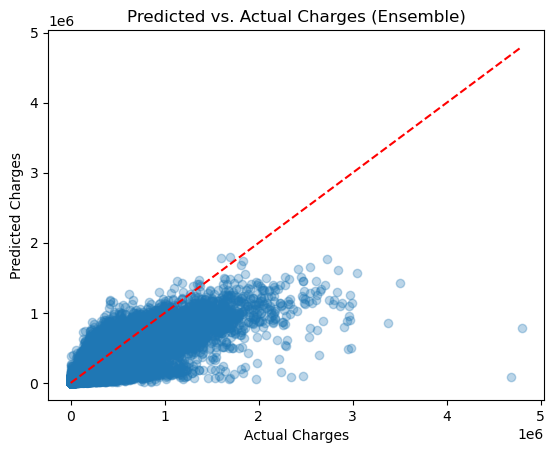

In [23]:
import matplotlib.pyplot as plt
plt.scatter(y_true, y_pred, alpha=0.3)
plt.plot([0, y_true.max()], [0, y_true.max()], 'r--')  # perfect line
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Predicted vs. Actual Charges (Ensemble)")
plt.show()

## Identify and Isolate Worst-Case Residuals

In [ ]:
# Create residuals column
df_with_preds['residual'] = abs(df_with_preds['ensemble_prediction'] - df_with_preds['total_charges'])

# Sort and extract worst 2,500 residuals
worst_2500 = df_with_preds.sort_values(by='residual', ascending=False).head(2500)

# worst_2500.to_csv('../data/ensemble_worst_2500_residuals.csv', index=False)

### Load Mapping Files

In [10]:
worst_2500 = pd.read_csv('../data/ensemble_worst_2500_residuals.csv')

# Load mapping tables
proc_map = pd.read_csv('../data/procedure_mapping.csv')
county_map = pd.read_csv('../data/county_mapping.csv')
age_map = pd.read_csv('../data/age_group_mapping.csv')
gender_map = pd.read_csv('../data/gender_mapping.csv')
severity_map = pd.read_csv('../data/severity_mapping.csv')
admit_map = pd.read_csv('../data/admission_type_mapping.csv')
payment_map = pd.read_csv('../data/payment_type_mapping.csv')
diag_map = pd.read_csv('../data/diagnosis_mapping.csv')

### Merge All Mappings

In [11]:
# Merge step-by-step
labeled = (
    worst_2500
    .merge(proc_map, on='procedure_encoded', how='left')
    .merge(county_map, on='county_encoded', how='left')
    .merge(age_map, on='age_group_encoded', how='left')
    .merge(gender_map, on='gender_encoded', how='left')
    .merge(severity_map, on='severity_encoded', how='left')
    .merge(admit_map, on='admission_encoded', how='left')
    .merge(payment_map, on='payment_type_encoded', how='left')
)


In [12]:
labeled[['total_charges', 'ensemble_prediction', 'residual', 
         'ccs_procedure_description', 'hospital_county', 'age_group', 
         'gender', 'severity', 'admission_type', 'payment_type']].head()


,total_charges,ensemble_prediction,residual,ccs_procedure_description,hospital_county,age_group,gender,severity,admission_type,payment_type
0,4687203.67,91254.953286,4.595949e+06,PERC TRANSLUM COR ANGIO,Nassau,70 or Older,M,Major,Emergency,Medicare
1,4795125.93,780762.787798,4.014363e+06,ELECTROENCEPHALOGRAM,Manhattan,0 to 17,M,Major,Emergency,Private Health Insurance
2,3374148.52,857256.353396,2.516892e+06,UP GASTRO ENDOSC/BIOPSY,Westchester,18 to 29,M,Extreme,Elective,Private Health Insurance
3,2981283.62,498942.368545,2.482341e+06,COLORECTAL RESECTION,Manhattan,50 to 69,M,Minor,Urgent,Medicaid
4,2953401.10,490709.387858,2.462692e+06,OTHER OR THER NERV SYS,Manhattan,0 to 17,M,Minor,Emergency,Other


### High-Error Procedures
Goal: Find which procedures consistently have the highest prediction errors.

In [22]:
proc_residuals = (
    labeled.groupby('ccs_procedure_description')
    .agg(avg_residual=('residual', 'mean'), count= ('residual', 'size'))
    .query('count >= 5')  # Only include procedures with 5+ cases
    .sort_values(by='avg_residual', ascending=False)
    .head(10)
)

proc_residuals

,avg_residual,count
ccs_procedure_description,,
PERC TRANSLUM COR ANGIO,1.035831e+06,8
UP GASTRO ENDOSC/BIOPSY,1.026019e+06,6
ELECTROENCEPHALOGRAM,9.806119e+05,16
INGUINAL/FEMORAL HERNIA,8.781277e+05,7
OT VASCULAR BYP/SHUNT,7.822588e+05,13
DIAGNOSTIC SPINAL TAP,7.597933e+05,10
EXTRA CIRC AUX OPEN HRT,7.437974e+05,89
NO PROC,7.422123e+05,19
OT ORGAN TRANSPLANTATN,7.237487e+05,106


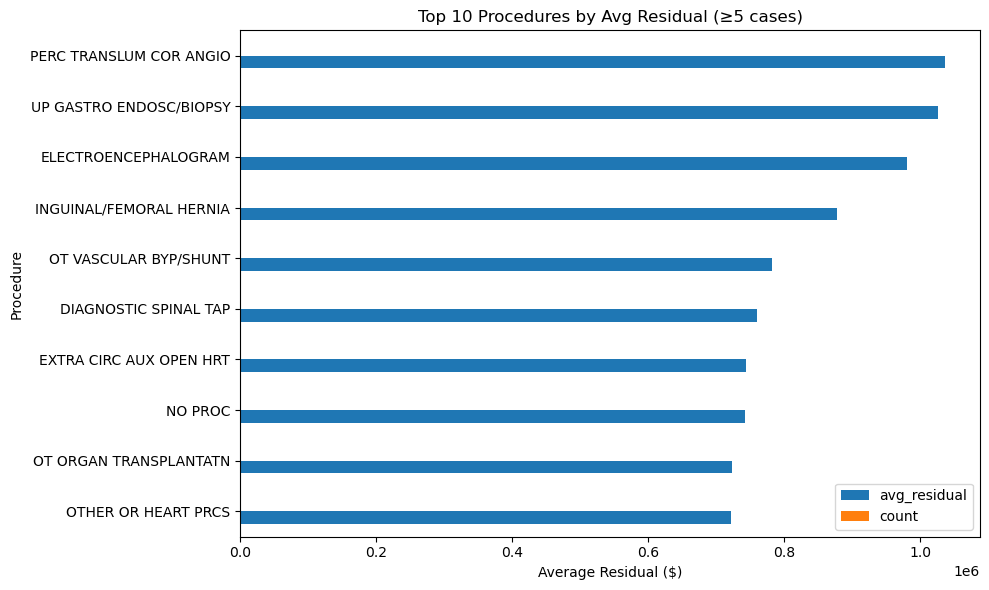

In [23]:
proc_residuals.sort_values(by='avg_residual').plot.barh(figsize=(10, 6))
plt.title('Top 10 Procedures by Avg Residual (≥5 cases)')
plt.xlabel('Average Residual ($)')
plt.ylabel('Procedure')
plt.tight_layout()
plt.show()


This chart shows the **top 10 procedures** with the highest average residuals among the 2,500 worst-predicted cases (only procedures with ≥5 occurrences included).

- **PERC TRANSLUM COR ANGIO** and **UP GASTRO ENDOSC/BIOPSY** had the largest underpredictions, with average residuals close to $1 million.

- Several high-error procedures, such as **ELECTROENCEPHALOGRAM** and **INGUINAL/FEMORAL HERNIA**, are common but variable in cost, possibly due to differences in setting (e.g., emergency vs. outpatient).

- **NO PROC** appearing in the top 10 suggests that missing or unrecorded procedures may confuse the model.

